In [2]:
import os
from functools import partial
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
from pyro import optim, poutine

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

df.head()

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343


アフリカ (`cont_africa` が `1`) の国と、そうでない国のデータをプロットする。
横軸 `rugged` は「でこぼこ度合い」を、縦軸 `rgdppc_2000` は対数変換された 2000 年の一人あたり GDP を表している。
詳細は https://diegopuga.org/data/rugged/ を参照のこと。

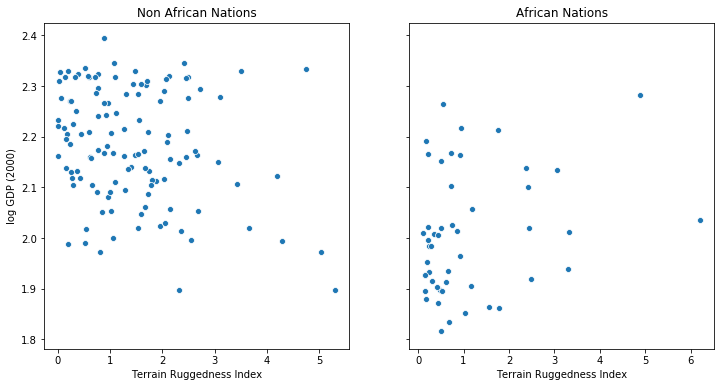

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            np.log(non_african_nations["rgdppc_2000"]),
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
            np.log(african_nations["rgdppc_2000"]),
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")
plt.show()

回帰モデルを構築する。入力 $\mathbf{x} = (x_1, x_2)^\top \in \mathbb{R}^2$ に対して、次の関数で $y$ の予測を行う。

$$
f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b + \lambda x_1 x_2
$$

- $y$: GDP
- $x_1$: 1 ならアフリカ、0 ならそれ以外の国
- $x_2$: でこぼこ指数

In [64]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p is the number of features
        super(RegressionModel, self).__init__()
        # 2 次元ベクトルの線型結合 + バイアス項
        self.linear = nn.Linear(p, 1)
        # 1 で初期化された、スカラのパラメータ
        self.factor = nn.Parameter(torch.tensor(1.))
        
    def forward(self, x):
        return self.linear(x) + (self.factor * x[:,0] * x[:,1]).unsqueeze(1)

p = 2
regression_model = RegressionModel(p)

In [65]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)
num_iterations = 1000
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:,:-1], data[:,-1]

In [66]:
def main():
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        y_pred = regression_model(x_data).squeeze(-1)
        loss = loss_fn(y_pred, y_data)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j+1, loss.item()))
            
    print("learned parameters:")
    for name, param in regression_model.named_parameters():
        print('   ', name, param.data.numpy())

main()

[iteration 0050] loss: 2963.0483
[iteration 0100] loss: 1552.2606
[iteration 0150] loss: 1067.9919
[iteration 0200] loss: 783.2891
[iteration 0250] loss: 577.3548
[iteration 0300] loss: 426.2773
[iteration 0350] loss: 320.6093
[iteration 0400] loss: 250.5237
[iteration 0450] loss: 206.3334
[iteration 0500] loss: 179.7908
[iteration 0550] loss: 164.5820
[iteration 0600] loss: 156.2609
[iteration 0650] loss: 151.9114
[iteration 0700] loss: 149.7387
[iteration 0750] loss: 148.7014
[iteration 0800] loss: 148.2280
[iteration 0850] loss: 148.0217
[iteration 0900] loss: 147.9357
[iteration 0950] loss: 147.9015
[iteration 1000] loss: 147.8886
learned parameters:
    factor 0.3860868215560913
    linear.weight [[-1.93287063 -0.19712977]]
    linear.bias [ 9.21129704]


## ベイズ回帰

線形回帰モデルをベイズ風にするには、パラメータ $w$, $b$ に対して事前分布を設定する必要があります。これらの分布はパラメータに対する（一般的に期待される）経験的な知識をモデルに与えます。

上の目的の為、既にあるモデルのパラメータを確立変数へと「昇格」させます。
Pyro では `random_module()` を用いて、任意の `nn.Module` を効率的に同じ機能を果たす確率モデルバージョンへと変換できます。
今回の場合だと、回帰モデルへの分布ということになります。
具体的には、オリジナルの回帰モデルの各パラメータは、与えられた事前分布からサンプルされることになります。
これによって、ただの回帰モデルをベイジアンの設定で使えるモデルへと再生することが出来ます。

例えば：
```py
lifted_module = pyro.random_module("module", original_model, prior)
```


In [45]:
def model(x_data, y_data):
    w_prior = Normal(torch.zeros(1,2), torch.ones(1,2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.)
    priors = {
        'linear.weight': w_prior,
        'linear.bias': b_prior,
        'factor': f_prior
    }
    scale = pyro.sample("sigma", Uniform(0., 10.))
    lifted_module = pyro.random_module("module", regression_model, priors)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        pyro.sample("obs",
                   Normal(prediction_mean, scale),
                   obs=y_data)
        return prediction_mean

In [46]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [47]:
optim = Adam({'lr': 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [49]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        loss = svi.step(x_data, y_data)
        if j % 100 == 0:
            print(f"[it {j:04d}] loss: {loss:.2f}")
            
train()

[it 0000] loss: 1375.37
[it 0100] loss: 574.82
[it 0200] loss: 539.32
[it 0300] loss: 512.62
[it 0400] loss: 478.98
[it 0500] loss: 422.47
[it 0600] loss: 373.87
[it 0700] loss: 285.75
[it 0800] loss: 256.85
[it 0900] loss: 258.77


In [50]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-2.1951,  0.3876, -1.8026, -0.1695,  9.1933], requires_grad=True)
auto_scale tensor([0.1678, 0.0773, 0.1376, 0.0563, 0.1042], grad_fn=<AddBackward0>)


## モデル評価

- モデル評価のために、予測値の生成と事後分布のプロットを行う
- 変分分布は完全にパラメトリックなモデルなので、リフト済みモデルをフォワード推論するだけで良い
- `Delta` 分布

In [51]:
def get_marginal(traces, sites):
    em =  EmpiricalMarginal(traces, sites)
    return em._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        percentiles = [.05, 0.25, 0.5, 0.75, 0.95]
        describe = partial(pd.Series.describe, percentiles=percentiles)
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))
    
posterior = svi.run(x_data, y_data)

In [54]:
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'Terrain Ruggedness Index'),
 Text(0.5,1,'African Nations')]

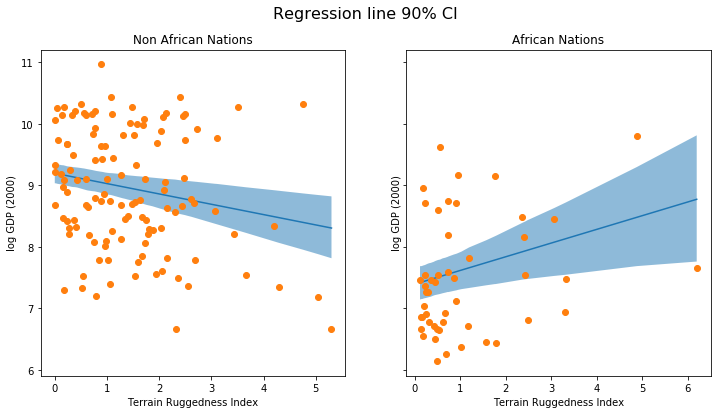

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

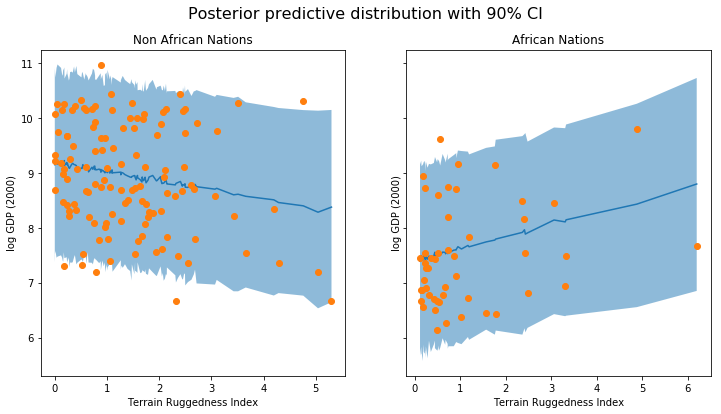

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")
plt.show()

Text(0.5,0.98,'Density of Slope : log(GDP) vs. Terrain Ruggedness')

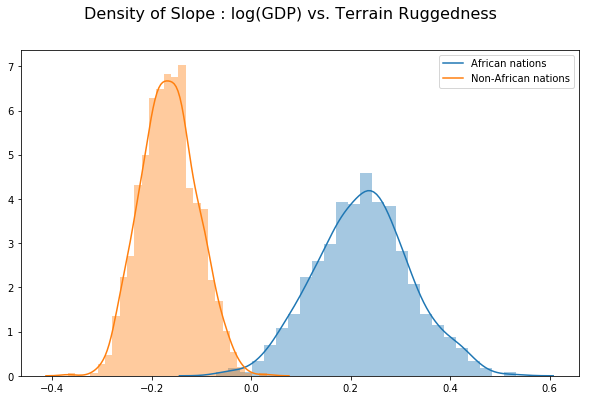

In [58]:
weight = get_marginal(posterior, ['module$$$linear.weight']).squeeze(1).squeeze(1)
factor = get_marginal(posterior, ['module$$$factor'])
gamma_within_africa = weight[:, 1] + factor.squeeze(1)
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)